# Magnetic field in dust dominated bouncing cosmology

In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a dust-like fluid.

The scale factor for this model is given by:
\begin{equation}
\frac{a(t)}{a_0} = \frac{1}{x_b}\left[1 + \left(\frac{t}{t_b}\right)^2\right]^{1/3}, \quad x \equiv \frac{a_0}{a}, \quad x_b \equiv \frac{a_0}{a_b},
\end{equation}
where $a_b$ gives the value of the scale factor at the bounce ($t = 0$), and $t_b$ the bounce time-scale. Solving the time $t$ in terms of the scale factor and substituting back to the Hubble function we can relate the free parameter $t_b$ with the dimensionless density $\Omega_m$, i.e.,
\begin{equation}
H^2 = \left(\frac{\dot a}{a}\right)^2 = \frac{4}{9}\frac{x^3}{t_b^2x_b^3} - \frac{4}{9}\frac{x^6}{t_b^2x_b^6} = \frac{1}{R_H^2}\left(\Omega_m x^3 + \Omega_Q x^6\right) \quad\Rightarrow\quad t_b = \frac{2}{3}\frac{R_H}{\sqrt{\Omega_m x_b^3}}, \quad \Omega_Q = - \frac{\Omega_m}{x_b^3}.
\end{equation}
where $R_H \equiv 1/H_0$ is the Hubble radius today and $\Omega_m$ is the dimensionless matter density today.

From here on we will express everything in unit of the Hubble radius, $t \to t/R_H$ and $t_b \to t_b / R_H$.

The electromagnetic vector field satisfy the following Hamilton equations:
\begin{equation}
\dot{A} = \frac{\Pi_A}{m}, \qquad \dot{\Pi}_A = -m\nu^2 A, \qquad m \equiv a F,\quad \nu = \frac{k}{a},\qquad F \equiv \frac{1}{4}\left(1+l_*^2 R\right), \qquad R = 6\left[\frac{\ddot{a}}{a}+\left(\frac{\dot{a}}{a}\right)^2\right].
\end{equation}
for the mode $k$. It is convenient to rewrite $F$ as
\begin{equation}
F = \frac{1}{4}\left\{1+c_*^2\frac{\left(t/t_b\right)^2+3}{\left[\left(t/t_b\right)^2+1\right]^2}\right\}, \qquad c_* \equiv \frac{2}{\sqrt3}\frac{l_*}{t_b}.
\end{equation}


## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries.

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm



# A helper function to write latex formatted numbers

In [2]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
          return r"10^{{{1}}}".format (int(exponent))
        else:
          return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Initializing the library

In [3]:
Ncm.cfg_init ()

# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
class PyCSQ1DMagDust (Ncm.CSQ1D):
  def __init__ (self, Omega_m = 0.3, xb = 1.0e25, cc = 1.0, h = 0.7):
    Ncm.CSQ1D.__init__ (self)

    self.h       = h
    self.Omega_m = Omega_m
    self.xb      = xb
    self.tb      = (2.0 / 3.0) * (1.0 / math.sqrt (Omega_m * xb**3))
    self.cc      = cc
    self.RH      = (Ncm.C.c () / (1.0e5 * h)) # Hubble radius in units of Mpc

  # Scale factor over scale factor today
  def y_t (self, t):
    tbar  = t / self.tb
    tbar2 = tbar * tbar

    return np.cbrt (1.0 + tbar2) / self.xb
  
  # The Hubble function
  def H_t (self, t):
    tbar  = t / self.tb
    tbar2 = tbar * tbar
    
    return (2.0 / 3.0 * tbar / (1.0 + tbar2)) / self.tb

  # The function $F$ defined above
  def F_t (self, t):
    cc    = self.cc
    cc2   = cc**2
    tbar  = t / self.tb
    tbar2 = tbar * tbar
    
    return 0.25 * (1.0 + cc2 * (tbar2 + 3.0) / (tbar2 + 1.0)**2)
    
  def do_eval_xi (self, model, t, k):
    return math.log (k) + math.log (self.F_t (t))

  def do_eval_nu (self, model, t, k):
    return k / self.y_t (t)

  def do_eval_nu2 (self, model, t, k):
    return (k / self.y_t (t))**2

  def do_eval_m (self, model, t, k):
    return self.y_t (t) * self.F_t (t)

  def do_eval_F1 (self, model, t, k):
    cc    = self.cc
    cc2   = cc**2
    tbar  = t / self.tb
    tbar2 = tbar * tbar
    tbar3 = tbar2 * tbar
    tbar4 = tbar2 * tbar2
    
    test = 1.0
    if t != 0.0:
      test  = max (1.0, cc2) / tbar2

    if test**3 < 1.0e-15:
      prefac = -2.0 * cc2 / (self.tb * tbar3)
      series = 1.0 + (2.0 - cc2) / tbar2 + (-9.0 - 3.0 * cc2 + cc2**2) / tbar4
      return prefac * series / (2.0 * self.do_eval_nu (model, t, k))
    else:
      T1 = -2.0 * cc2 * tbar * (tbar2 + 5.0)
      T2 = tbar2 + 1.0
      T3 = T2**2
      T4 = cc2 * (tbar2 + 3.0)

      return (T1 / (T2 * (T3 + T4) * self.tb)) / (2.0 * self.do_eval_nu (model, t, k))

  def do_eval_F2 (self, model, t, k):
    cc    = self.cc
    cc2   = cc**2
    tbar  = t / self.tb
    tbar2 = tbar * tbar
    tbar4 = tbar2 * tbar2
    tbar6 = tbar4 * tbar2
    
    test = 1.0
    if t != 0.0:
      test  = max (1.0, cc2) / tbar2

    if test**3 < 1.0e-15:
      prefac = 14.0 * cc2 / (3.0 * tbar4 * self.tb**2)
      series = 1.0 + (4.0 - 13.0 * cc2 / 7.0) / tbar2 + (-169.0 - 59.0 * cc2 + 19.0 * cc2**2) / (7.0 * tbar4)
      return prefac * series / (2.0 * self.do_eval_nu (model, t, k))**2
    else:
      T1    = (2.0 / 3.0) * cc2 / self.tb**2
      T2    = cc2 * (-45.0 + 3.0 * tbar2 + 17.0 * tbar4 + tbar6)
      T3    = (1.0 + tbar2)**2
      T4    = (-15.0 + 7.0 * tbar2 * (8.0 + tbar2))
      T5    = (T3 + cc2 * (3.0 + tbar2))**2
      return (T1 * (T2 + T3 * T4) / (T3 * T5)) / (2.0 * self.do_eval_nu (model, t, k))**2

  def do_prepare (self, model):
    pass 

  def eval_PB_PE (self, t):
    (J11, J12, J22) = self.get_J_at (None, t)
    A2   = 0.5 * J11
    PiA2 = 0.5 * J22
    F    = self.F_t (t)
    xb   = self.xb
    k    = self.get_k ()
    y    = self.y_t (t)
    RH   = self.RH
    m    = self.eval_m (None, t, k)
    PE   = PiA2   * (k / y)**3 / (2.0 * math.pi**2 * RH**4 * m)
    PB   = m * A2 * (k / y)**5 / (2.0 * math.pi**2 * RH**4)

    return PE, PB


In [5]:
csq1d = PyCSQ1DMagDust (cc = 1.0e20)

ki    = 1.0
kf    = 4.0e4
k_a   = np.geomspace (ki, kf, 3)

csq1d.set_k (kf)
(Found2, tf) = csq1d.find_adiab_time_limit (None, +1.0e-25, +1.0e15, 1.0e0)

print (Found2, tf)

True 2.9831064587928164e-14


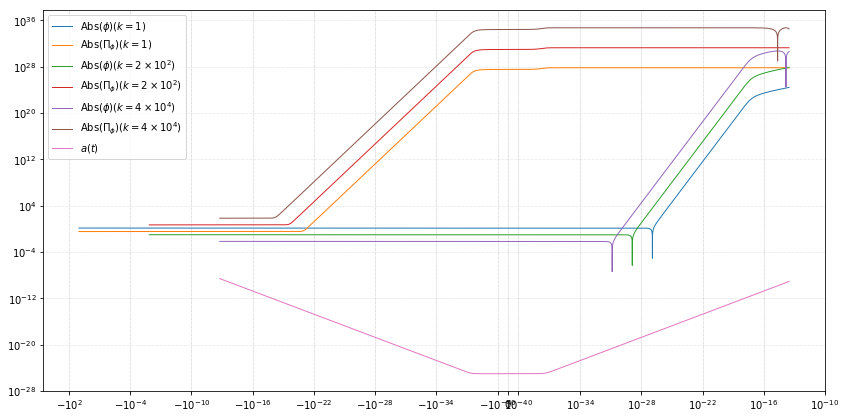

In [6]:
plt.figure (figsize=(14, 7))

for k in k_a:
  csq1d.set_k (k)
  csq1d.set_reltol (1.0e-12)
  csq1d.set_save_evol (True)

  #print (csq1d.eval_adiab_at (None, -5))

  (Found1, ti)  = csq1d.find_adiab_time_limit (None, -1.0e15, -1.0e-25, 1.0e-1)
  #print (Found1, ti)
    
  csq1d.set_ti (ti)
  csq1d.set_tf (tf)
  csq1d.prepare ()

  t_a, t_s = csq1d.get_time_array ()
  alpha_a   = []
  dgamma_a  = []

  Re_phi_a  = []
  Im_phi_a  = []
  Re_Pphi_a = []
  Im_Pphi_a = []
  y_a       = []

  for t in t_a:
    alpha, dgamma = csq1d.eval_at (t)
    alpha_a.append (alpha)
    dgamma_a.append (dgamma)
    (phi, Pphi) = csq1d.alpha_dgamma_to_phi_Pphi (None, t, alpha, dgamma)
    Re_phi_a.append (phi[0])
    Im_phi_a.append (phi[1])
    Re_Pphi_a.append (Pphi[0])
    Im_Pphi_a.append (Pphi[1])
    y_a.append (csq1d.y_t (t))

  y_a = np.array (y_a)

  mylw = 1

  plt.plot (t_a, np.hypot (Re_phi_a, Im_phi_a),   lw=mylw, label = r'$\mathrm{Abs}(\phi)(k = %s)$' % latex_float (k))
  plt.plot (t_a, np.hypot (Re_Pphi_a, Im_Pphi_a), lw=mylw, label = r'$\mathrm{Abs}(\Pi_\phi)(k = %s)$' % latex_float (k))
  #plt.plot (t_a, np.abs (alpha_a),  lw=mylw, label = r'$\alpha(%e)$' % k)
  #plt.plot (t_a, np.abs (dgamma_a), lw=mylw, label = r'$\Delta\gamma(%e)$' % k)

plt.plot (t_a, y_a, lw=mylw, label = r'$a(t)$')

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best")
plt.xscale('symlog', linthreshx = t_s)
plt.yscale('log')

plt.savefig('MagDustModeEvol.pdf')
plt.show ()



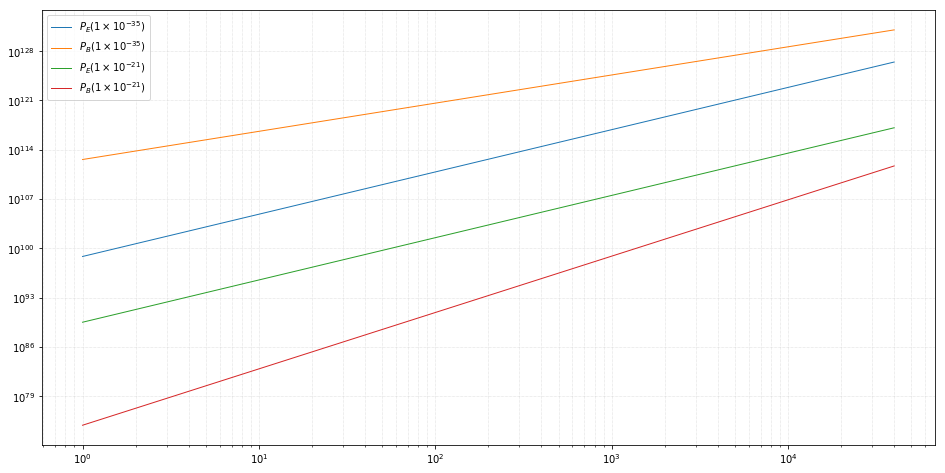

In [7]:
plt.figure (figsize=(16, 8))

ki    = 1.0
kf    = 4.0e4
k_a   = np.geomspace (ki, kf, 10)
PB1_a = []
PE1_a = []
PB2_a = []
PE2_a = []

tf1 = 1.0e-35
tf2 = 1.0e-21

for k in k_a:
  csq1d.set_k (k)
  csq1d.set_reltol (1.0e-12)
  csq1d.set_save_evol (True)

  (Found1, ti)  = csq1d.find_adiab_time_limit (None, -1.0e15, -1.0e-25, 1.0e-1)
    
  csq1d.set_ti (ti)
  csq1d.set_tf (tf)
  csq1d.prepare ()

  (PE1, PB1) = csq1d.eval_PB_PE (tf1)
  PB1_a.append (PB1)
  PE1_a.append (PE1)

  (PE2, PB2) = csq1d.eval_PB_PE (tf2)
  PB2_a.append (PB2)
  PE2_a.append (PE2)

mylw = 1

plt.plot (k_a, PE1_a,   lw=mylw, label = r'$P_E(%s)$' % latex_float (tf1))
plt.plot (k_a, PB1_a,   lw=mylw, label = r'$P_B(%s)$' % latex_float (tf1))

plt.plot (k_a, PE2_a,   lw=mylw, label = r'$P_E(%s)$' % latex_float (tf2))
plt.plot (k_a, PB2_a,   lw=mylw, label = r'$P_B(%s)$' % latex_float (tf2))

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best")

plt.xscale('log')
plt.yscale('log')

plt.savefig('MagDustPS.pdf')
plt.show ()
